# How to use the models we trained

In [1]:
# !pip install -U opencv-python tabula-py

In [1]:
%load_ext autoreload
%autoreload 2

import os, numpy, glob, collections, random, shutil, pandas, time, subprocess, itertools, cv2
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= ""

from PIL import Image
from IPython.display import display, SVG
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%pylab inline

from keras import backend as K
from keras.models import load_model
from keras.objectives import binary_crossentropy

import tabula

Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


In [4]:
smooth = 1e-12

def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    union = K.sum(y_true + y_pred, axis=[0, 1, 2])
    dice = (intersection + smooth) / (union - intersection + smooth)
    return K.mean(dice)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_ce_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

# segmentation_model = load_model('./models/contours.h5', custom_objects=dict(dice_coef_loss=dice_coef_loss))
segmentation_model = load_model('./models/hbf1.h5',
                                custom_objects=dict(dice_coef_loss=dice_coef_loss,
                                                    dice_coef=dice_coef,
                                                    dice_ce_loss=dice_ce_loss))

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [42]:
def arr_to_img(arr):
    return Image.fromarray((arr * 255).astype('uint8'))


def arr3_to_img(arr):
    arr = numpy.rollaxis(arr, 0, 2).reshape((arr.shape[1], arr.shape[0] * arr.shape[2])+arr.shape[3:])
    print(arr.shape)
    return arr_to_img(arr)


def to_grayscale(arr):
    return arr.mean(axis=-1)


def identity(x):
    return x


def rgba_to_rgb(image, color=(255, 255, 255)):
    image.load()  # needed for split()
    background = Image.new('RGB', image.size, color)
    background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
    return background


def la_to_l(image, color=255):
    image.load()  # needed for split()
    background = Image.new('L', image.size, color)
    background.paste(image, mask=image.split()[-1])  # 3 is the alpha channel
    return background


def load_image_to_array(fname, proc=identity, mode=None):
    img = Image.open(fname)
    if not mode is None and img.mode != mode:
        if img.mode == 'LA':
            img = la_to_l(img)
        elif img.mode == 'RGBA':
            img = rgba_to_rgb(img)
        img = img.convert(mode)
    return proc(numpy.array(img))


def read_images_to_tensor(filenames, n_jobs=20, proc=identity, mode='RGB'):
    data = list(Parallel(n_jobs=n_jobs)(delayed(load_image_to_array)(fname, proc=proc, mode=mode)
                                        for fname in filenames))
    return numpy.stack(data).astype('float32') / 255.0


def segment_images(model, image_fnames, output_threshold=0.8, **read_kwargs):
    img_data = read_images_to_tensor(image_fnames, **read_kwargs)
    return binarize_tensor(model.predict(img_data).reshape(img_data.shape[:-1]),
                           threshold=output_threshold)


WINDOW_SIZE = (500, 500)
STRIDE = (50, 50)
OUT_SCALE_TO = (256, 256)
OUT_MODE = 'L'
ROTATIONS = (0, 90, 180, 270)
DENSITY = 72
PIXELS_TO_POINTS_FACTOR = 1 # DENSITY / 72.0 # convert does not respect density and resample when converting to png


def pdf_to_pages(in_file, out_dir):
    subprocess.check_call(['convert', in_file,
                           '-density', str(DENSITY),
                           '-resample', '{0}x{0}'.format(DENSITY),
                           os.path.join(out_dir, '%04d.png')])
    return list(glob.glob(os.path.join(out_dir, '*.png')))


def augment_image_deterministic(fname, out_dir):
    out_i = 0
    base_fname = os.path.splitext(os.path.basename(fname))[0]
    src_img = Image.open(fname).convert('RGB').convert(OUT_MODE)

    offset_gen = itertools.product(range(0,
                                         src_img.size[0] - WINDOW_SIZE[0],
                                         STRIDE[0]),
                                   range(0,
                                         src_img.size[1] - WINDOW_SIZE[1],
                                         STRIDE[1]))
    for x_off, y_off in offset_gen:
        new_image = src_img.crop((x_off,
                                  y_off,
                                  x_off + WINDOW_SIZE[0],
                                  y_off + WINDOW_SIZE[1]))
        new_image.thumbnail(OUT_SCALE_TO)
        for angle in ROTATIONS:
            out_fname = os.path.join(out_dir,
                                     '_'.join((base_fname,
                                               str(out_i))) + '.png')
            new_image.rotate(angle).save(out_fname)
            yield (x_off, y_off, angle, out_fname)
            out_i += 1


# Network outputs:
# (Footer, Header, Body)


def process_page(segm_model, full_image_fname, out_dir, mask_threshold=0.8, min_contour_area=100, read_mode='L', read_proc=identity):
    transformations = list(augment_image_deterministic(full_image_fname, out_dir))
    transformed_images = numpy.expand_dims(read_images_to_tensor([f for _, _, _, f in transformations], mode=read_mode, proc=read_proc),
                                           -1)
    partial_masks = segm_model.predict(transformed_images)
    page_image = Image.open(full_image_fname).convert('RGB').convert(OUT_MODE)
    print(page_image.size)
    aggregated_mask = numpy.zeros((page_image.size[1], page_image.size[0], 3),
                                  dtype='float32')
    norm = numpy.zeros_like(aggregated_mask)
    for (x_off, y_off, angle, _), mask_pixels in zip(transformations, partial_masks):
        mask_width = min(WINDOW_SIZE[0], aggregated_mask.shape[1] - x_off)
        mask_height = min(WINDOW_SIZE[1], aggregated_mask.shape[0] - y_off)

        mask = arr_to_img(mask_pixels)
        mask = mask.rotate(-angle).resize((mask_width, mask_height), Image.BILINEAR)
        mask_pixels = numpy.array(mask)
        aggregated_mask[y_off:y_off+mask_pixels.shape[1],
                        x_off:x_off+mask_pixels.shape[0]] += mask_pixels
        norm[y_off:y_off+mask_pixels.shape[1],
             x_off:x_off+mask_pixels.shape[0], :] += 1
    aggregated_mask /= norm
    aggregated_mask = binarize_tensor(aggregated_mask, mask_threshold * 255.0)

    contours = [(channel,
                 cv2.findContours((aggregated_mask[:, :, channel]).astype('uint8'),
                                  cv2.RETR_LIST,
                                  cv2.CHAIN_APPROX_SIMPLE)[1])
                for channel in range(3)]
    result = []
    demo_mask = numpy.zeros(aggregated_mask.shape, dtype='uint8')
    for channel, cur_contours in contours:
        for cnt in cur_contours:
            if cv2.contourArea(cnt) < min_contour_area:
                continue
            x, y, w, h = cv2.boundingRect(cnt)
            result.append((channel, numpy.array([y, x, y+h, x+w]) * PIXELS_TO_POINTS_FACTOR))
            color = [0] * 3
            color[channel] = 255
            cv2.drawContours(demo_mask,
                             [numpy.array([(x, y),
                                            (x + w, y),
                                            (x + w, y + h),
                                            (x, y + h)])],
                             -1,
                             tuple(color),
                             cv2.FILLED)

    demo_mask = arr_to_img(demo_mask.astype('float32') / 255.0)
    print(page_image.size, demo_mask.size)
    display(Image.blend(page_image.convert('RGB'), demo_mask, 0.5))
    return result

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


(632, 812)
(632, 812) (632, 812)


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


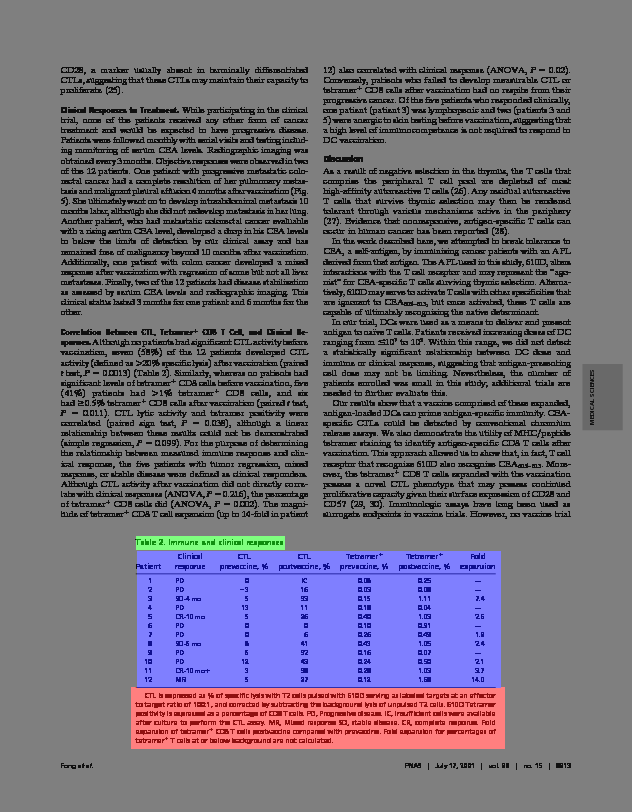

[(0, array([687, 131, 748, 504])),
 (1, array([536, 136, 549, 284])),
 (2, array([551, 137, 687, 500]))]

In [46]:
# page_filenames = pdf_to_pages('/notebook/data/tmp/11427731.pdf', '/notebook/data/tmp/pages')
table_coords = process_page(segmentation_model, '/notebook/data/tmp/pages/0004.png', '/notebook/data/tmp/pages/page_buf/',
                            mask_threshold=0.5)
table_coords